<a href="https://colab.research.google.com/github/catpixie-47/FDIP/blob/main/microplastics_FDIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/microplastics_project/{images,annotations,models,notebooks,results}
!ls -la /content/drive/MyDrive/microplastics_project


total 20
drwx------ 2 root root 4096 Oct  7 16:47 annotations
drwx------ 2 root root 4096 Oct  7 16:47 images
drwx------ 2 root root 4096 Oct  7 16:47 models
drwx------ 2 root root 4096 Oct  7 16:47 notebooks
drwx------ 2 root root 4096 Oct  7 16:47 results


In [ ]:
!pip install -q pycocotools albumentations opencv-python-headless matplotlib tqdm


In [ ]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.8.0+cu126
cuda available: True


Detected particles: 1


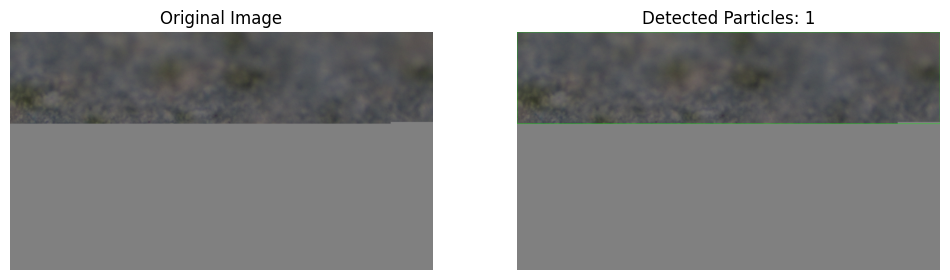

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your uploaded image
img_path = "/content/SLB_S03_A_L_1.jpg"

# Step 1: Read the image
img = cv2.imread(img_path)
if img is None:
    raise ValueError("Image not found. Check file name or path!")

# Step 2: Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 3: Apply Gaussian blur to reduce noise
blur = cv2.GaussianBlur(gray, (5,5), 0)

# Step 4: Thresholding (binarize image)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 5: Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 6: Draw bounding boxes and count detected particles
result = img.copy()
count = 0
for c in contours:
    area = cv2.contourArea(c)
    if area > 50:  # ignore very tiny particles (noise)
        count += 1
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)

print(f"Detected particles: {count}")

# Step 7: Display results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Particles: {count}")
plt.axis('off')

plt.show()


In [ ]:
import zipfile
import os

zip_path = "/content/archive (1).zip"
extract_dir = "/content/dataset"

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted files:")
print(os.listdir(extract_dir))


Extracted files:
['train', 'valid']


In [ ]:
print("Train images:", len(os.listdir("/content/dataset/train")))
print("Valid images:", len(os.listdir("/content/dataset/valid")))


Train images: 578
Valid images: 205


In [ ]:
import os

base_path = "/content/dataset"

for folder in os.listdir(base_path):
    path = os.path.join(base_path, folder)
    if os.path.isdir(path):
        print(f"📁 Folder: {folder}")
        inner_files = os.listdir(path)
        print(f"   Contains {len(inner_files)} files")
        print("   Sample files:", inner_files[:5])
        print("------")
    else:
        print(f"📄 File: {folder}")


📁 Folder: train
   Contains 578 files
   Sample files: ['c--117-_jpg.rf.8b728066bb99ac4f780f05e66c3ec2cb.jpg', '29_jpg.rf.2d7a802a59f28f44700485e2f7ad912b.jpg', 'd--83-_jpg.rf.705f949f88ba725cc39cf0a559ddfcf3.jpg', 'f--42-_jpg.rf.f3ae1202af7aee62610dee8451720b36.jpg', 'f--35-_jpg.rf.ab4368b505c59a4069b3c12c33a267b6.jpg']
------
📁 Folder: valid
   Contains 205 files
   Sample files: ['c--198-_jpg.rf.64a7077e222d5edccee5f0e2a272b284.jpg', 'c--95-_jpg.rf.040898b558cf72633e939a31415b00cf.jpg', 'f--11-_jpg.rf.3f002db831a7cff3ff47824394658d2d.jpg', 'c--36-_jpg.rf.095669007899fc6932329c83b4d21c68.jpg', 'c--55-_jpg.rf.fe4f8cfb75f3da70e30f98dfcced9d2c.jpg']
------


In [ ]:
!pip install tensorflow keras matplotlib numpy opencv-python

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Path setup
train_dir = '/content/train'
valid_dir = '/content/valid'

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content',
    classes=['train'],  # since all images are in 'train'
    target_size=(128,128),
    batch_size=32,
    class_mode=None)

valid_data = valid_datagen.flow_from_directory(
    '/content',
    classes=['valid'],
    target_size=(128,128),
    batch_size=32,
    class_mode=None)


Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [ ]:

import os
import pandas as pd
from IPython.display import display

train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/valid"

def inspect_csvs(folder):
    print(f"\n--- Inspecting folder: {folder} ---")
    csvs = [f for f in os.listdir(folder) if f.lower().endswith('.csv')]
    if not csvs:
        print("No CSV files found in", folder)
        return
    for c in csvs:
        path = os.path.join(folder, c)
        print("\nCSV file:", path)
        try:
            df = pd.read_csv(path)
        except Exception as e:
            try:
                df = pd.read_csv(path, sep=';')
                print("Read with sep=';'.")
            except Exception as e2:
                print("Failed to read CSV:", e, " / ", e2)
                continue
        print("Shape:", df.shape)
        print("Columns:", list(df.columns))
        print("\nFirst 10 rows:")
        display(df.head(10))
        # Quick column value checks
        for col in df.columns:
            try:
                nunique = df[col].nunique(dropna=True)
            except:
                nunique = None
            if df[col].dtype == 'O' or (isinstance(nunique, int) and nunique < 20):
                print(f"  -> Column `{col}` sample unique values (up to 10):", df[col].dropna().unique()[:10])
        # Detect filename-like columns
        filename_candidates = []
        for col in df.columns:
            try:
                sample = df[col].astype(str).dropna().head(50).str.lower()
                if sample.str.contains(r'\.jpg|\.jpeg|\.png|\.tif|\.tiff|\.npy', regex=True).any():
                    filename_candidates.append(col)
            except Exception:
                pass
        print("Filename-like columns detected:", filename_candidates)
        if filename_candidates:
            images_in_folder = set([f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png','.tif','.tiff','.npy'))])
            for col in filename_candidates:
                files_in_df = set(df[col].astype(str).str.strip())
                common = files_in_df & images_in_folder
                print(f"  Column `{col}`: entries in CSV = {len(files_in_df)}, images in folder = {len(images_in_folder)}, common = {len(common)}")
                print("  Examples (in CSV but not found in folder):", list(files_in_df - images_in_folder)[:10])
        print("\n-------------------------------")

inspect_csvs(train_dir)
inspect_csvs(valid_dir)

print("\nDone. Copy the printed outputs (shapes, columns, and any filename-like column info) here so I can recommend the exact next single action.")



--- Inspecting folder: /content/dataset/train ---

CSV file: /content/dataset/train/_annotations.csv
Shape: (5425, 8)
Columns: ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

First 10 rows:


,filename,width,height,class,xmin,ymin,xmax,ymax
0,177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg,563,537,Microplastic,102,170,123,196
1,177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg,563,537,Microplastic,395,247,424,281
2,177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg,563,537,Microplastic,160,254,188,290
3,177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg,563,537,Microplastic,187,307,213,346
4,177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg,563,537,Microplastic,175,379,209,427
5,a--100-_jpg.rf.77ca389cf7e6997bcae4d1bc8c86044...,563,537,Microplastic,276,60,338,137
6,a--100-_jpg.rf.77ca389cf7e6997bcae4d1bc8c86044...,563,537,Microplastic,24,221,105,302
7,a--100-_jpg.rf.77ca389cf7e6997bcae4d1bc8c86044...,563,537,Microplastic,122,196,200,285
8,a--100-_jpg.rf.77ca389cf7e6997bcae4d1bc8c86044...,563,537,Microplastic,218,187,301,282
9,a--100-_jpg.rf.77ca389cf7e6997bcae4d1bc8c86044...,563,537,Microplastic,130,404,202,480


  -> Column `filename` sample unique values (up to 10): ['177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg'
 'a--100-_jpg.rf.77ca389cf7e6997bcae4d1bc8c86044a.jpg'
 'd--38-_jpg.rf.7af616cb2ee6ec5bafbbe16be5f4c54d.jpg'
 '188_jpg.rf.79a80e683f2b355bf9c333b89b065d12.jpg'
 'b--74-_jpg.rf.7d61098f935873621ff43de4aa0e2754.jpg'
 'd--33-_jpg.rf.7b594b748ca1a20c06e43b85bc31bd75.jpg'
 'd--72-_jpg.rf.834f2832ac385eb81c5a5810faf514b2.jpg'
 'd--13-_jpg.rf.79e413c77f10a17c6d3c6286565f93df.jpg'
 '53_jpg.rf.7c216f083d98635b4f8d1debcbb8120a.jpg'
 'c--140-_jpg.rf.7b5cf5b5bcbb8695b6b4891cd32fbfbc.jpg']
  -> Column `width` sample unique values (up to 10): [563 353]
  -> Column `height` sample unique values (up to 10): [537 336]
  -> Column `class` sample unique values (up to 10): ['Microplastic']
Filename-like columns detected: ['filename']
  Column `filename`: entries in CSV = 577, images in folder = 577, common = 577
  Examples (in CSV but not found in folder): []

-------------------------------

--- Ins

,filename,width,height,class,xmin,ymin,xmax,ymax
0,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,271,15,305,46
1,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,348,265,402,308
2,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,146,279,181,317
3,c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...,563,537,Microplastic,477,302,542,367
4,f--28-_jpg.rf.de4fc5ebba3bbc0baea64e669225c7c5...,563,537,Microplastic,279,137,337,205
5,f--28-_jpg.rf.de4fc5ebba3bbc0baea64e669225c7c5...,563,537,Microplastic,0,184,18,250
6,f--28-_jpg.rf.de4fc5ebba3bbc0baea64e669225c7c5...,563,537,Microplastic,453,308,536,386
7,f--28-_jpg.rf.de4fc5ebba3bbc0baea64e669225c7c5...,563,537,Microplastic,192,497,282,536
8,a--67-_jpg.rf.def7d22e1de2a7d2ab101a2c750327ab...,563,537,Microplastic,334,141,428,219
9,a--67-_jpg.rf.def7d22e1de2a7d2ab101a2c750327ab...,563,537,Microplastic,194,207,288,297


  -> Column `filename` sample unique values (up to 10): ['c--188-_jpg.rf.df8c04f880e507f44d63d74b701f3810.jpg'
 'f--28-_jpg.rf.de4fc5ebba3bbc0baea64e669225c7c5.jpg'
 'a--67-_jpg.rf.def7d22e1de2a7d2ab101a2c750327ab.jpg'
 'c--5-_jpg.rf.e987df9bff6061ef3010945913a35d59.jpg'
 'c--34-_jpg.rf.e852f0fb16bb5a7204a0cf1670a3da31.jpg'
 'c--81-_jpg.rf.e52081310dbb8e3fff8e5ea663abba98.jpg'
 'f--15-_jpg.rf.f9cc0c09bcf07409978fc11d674e94b0.jpg'
 'c--172-_jpg.rf.e770140160fd7aaa0429c661fccffa66.jpg'
 'c--68-_jpg.rf.f08b69d4c04cc2b51516b5e1d71e6cef.jpg'
 'c--85-_jpg.rf.f6838c602dceccd3b68d69db59154172.jpg']
  -> Column `width` sample unique values (up to 10): [563]
  -> Column `height` sample unique values (up to 10): [537]
  -> Column `class` sample unique values (up to 10): ['Microplastic']
Filename-like columns detected: ['filename']
  Column `filename`: entries in CSV = 204, images in folder = 204, common = 204
  Examples (in CSV but not found in folder): []

-------------------------------

Done. 

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/valid"

def extract_microplastic_patches(img_dir):
    csv_path = os.path.join(img_dir, "_annotations.csv")
    df = pd.read_csv(csv_path)
    patches, labels = [], []

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['filename'])
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        crop = img[ymin:ymax, xmin:xmax]
        crop = cv2.resize(crop, (64, 64))
        patches.append(crop)
        labels.append(1)  # Microplastic present
    return np.array(patches), np.array(labels)

X_train, y_train = extract_microplastic_patches(train_dir)
X_valid, y_valid = extract_microplastic_patches(valid_dir)

X_train = X_train / 255.0
X_valid = X_valid / 255.0

print("Train patches:", X_train.shape)
print("Valid patches:", X_valid.shape)


Train patches: (5425, 64, 64, 3)
Valid patches: (1701, 64, 64, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')   # Binary classification: microplastic / non-microplastic
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Save model
model.save("microplastic_cnn_model.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9843 - loss: 0.0430 - val_accuracy: 1.0000 - val_loss: 5.2483e-27
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.0094e-21 - val_accuracy: 1.0000 - val_loss: 5.2483e-27
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.2199e-21 - val_accuracy: 1.0000 - val_loss: 5.2483e-27
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.6179e-22 - val_accuracy: 1.0000 - val_loss: 5.2483e-27
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.8771e-23 - val_accuracy: 1.0000 - val_loss: 5.2483e-27
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1364e-21 - val_accuracy: 1.0000 - val_loss: 5.2483e-27


In [ ]:
import pandas as pd
import os

# Path to your annotations CSV (change if needed)
csv_path = "/content/dataset/train/_annotations.csv"

# Read CSV
df = pd.read_csv(csv_path)

# Count how many bounding boxes per image
counts = df.groupby('filename').size().reset_index(name='microplastic_count')

print(counts.head())
print(f"\nTotal images: {counts.shape[0]}")
print(f"Average microplastics per image: {counts['microplastic_count'].mean():.2f}")


                                          filename  microplastic_count
0  100_jpg.rf.f1b9d16649ab385e3691fa54301a3b61.jpg                  13
1  106_jpg.rf.e8dc04354de3fadaea50922857adf45e.jpg                  15
2   10_jpg.rf.ecfa6fcdfec86c013936528ac959e40d.jpg                  19
3  110_jpg.rf.2c87278f41415f6dfc58e3844a3c61f3.jpg                  16
4  111_jpg.rf.43dd53d60dae89a68f02b58f3b167ad7.jpg                  15

Total images: 577
Average microplastics per image: 9.40


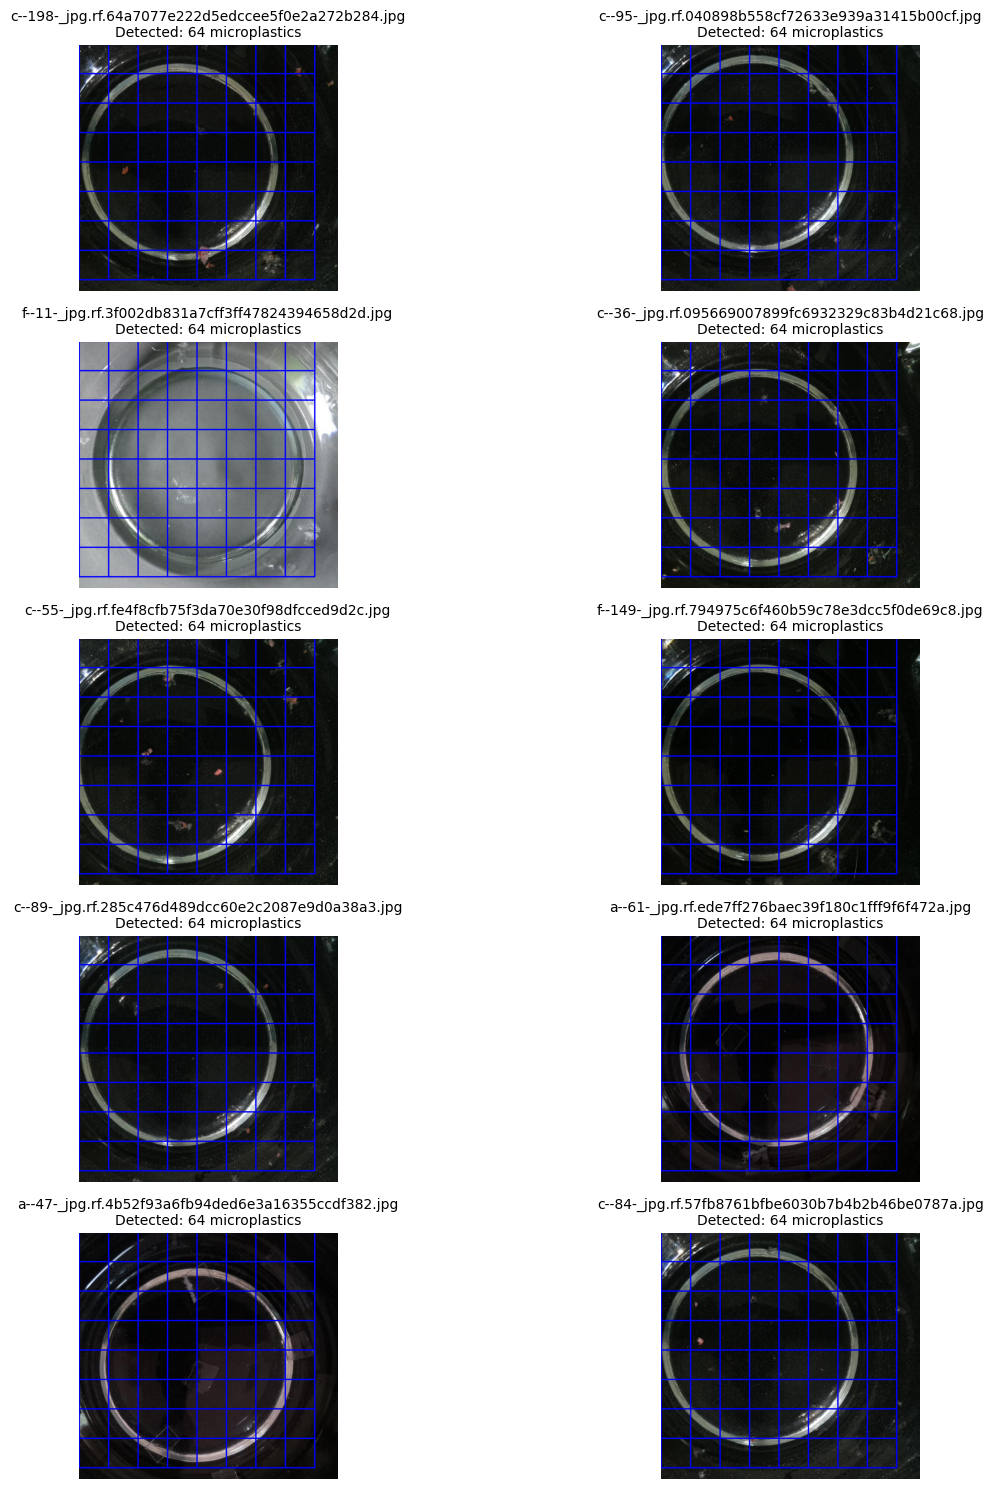

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained CNN model
model = load_model("microplastic_cnn_model.h5")

# Path to your images
image_dir = "/content/dataset/valid"   # or /content/dataset/train

# Detection function
def detect_microplastics_in_image(image_path, patch_size=64, step=64, threshold=0.2):
    img = cv2.imread(image_path)
    if img is None:
        return None, 0

    h, w, _ = img.shape
    result_img = img.copy()
    detected_count = 0

    for y in range(0, h - patch_size, step):
        for x in range(0, w - patch_size, step):
            patch = img[y:y+patch_size, x:x+patch_size]
            patch_input = np.expand_dims(patch / 255.0, axis=0)
            pred = model.predict(patch_input, verbose=0)[0][0]

            if pred > threshold:
                detected_count += 1
                cv2.rectangle(result_img, (x, y), (x+patch_size, y+patch_size), (255, 0, 0), 2)

    return result_img, detected_count


# Pick first 10 images to visualize
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))][:10]

plt.figure(figsize=(15, 15))

for idx, filename in enumerate(image_files):
    img_path = os.path.join(image_dir, filename)
    result_img, count = detect_microplastics_in_image(img_path, threshold=0.2)
    if result_img is not None:
        plt.subplot(5, 2, idx + 1)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{filename}\nDetected: {count} microplastics", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()


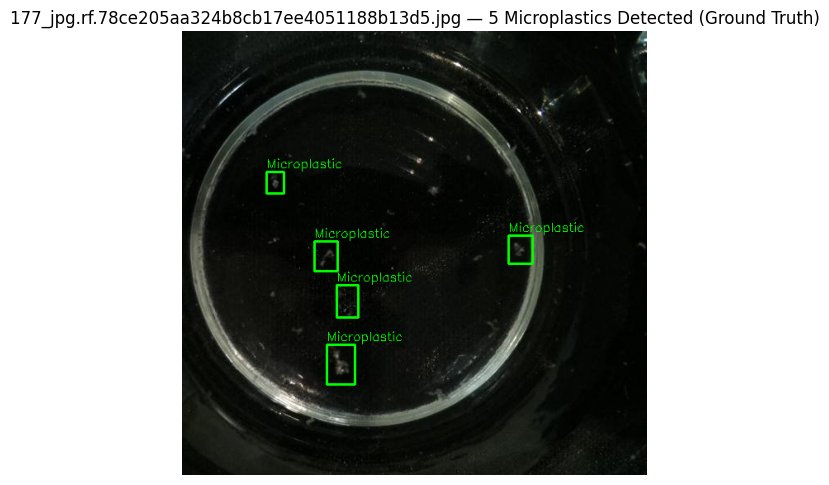

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path setup
img_dir = "/content/dataset/train"  # or valid
csv_path = os.path.join(img_dir, "_annotations.csv")

# Load annotations
df = pd.read_csv(csv_path)

# Function to visualize image with bounding boxes
def visualize_microplastics(image_name):
    img_path = os.path.join(img_dir, image_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Image not found: {image_name}")
        return

    # Get all bounding boxes for this image
    boxes = df[df["filename"] == image_name]
    for _, row in boxes.iterrows():
        xmin, ymin, xmax, ymax = int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"])
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, "Microplastic", (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{image_name} — {len(boxes)} Microplastics Detected (Ground Truth)")
    plt.axis("off")
    plt.show()

# 🔹 Example — visualize any image from your dataset
visualize_microplastics(df["filename"].iloc[0])  # you can change the index



In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import cv2

# Define paths
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/valid"
yolo_train_dir = "/content/dataset/train/labels"
yolo_valid_dir = "/content/dataset/valid/labels"
class_name = "Microplastic" # Your single class name
class_id = 0 # YOLO requires a class ID (starting from 0)

# Create label directories if they don't exist
os.makedirs(yolo_train_dir, exist_ok=True)
os.makedirs(yolo_valid_dir, exist_ok=True)

def convert_bbox_to_yolo(size, box):
    # Convert (xmin, ymin, xmax, ymax) to (x_center, y_center, width, height)
    # Normalized by image size
    dw = 1./size[0]
    dh = 1./size[1]
    x_center = (box[0] + box[1])/2.0
    y_center = (box[2] + box[3])/2.0
    width = box[1] - box[0]
    height = box[3] - box[2]
    x_center *= dw
    width *= dw
    y_center *= dh
    height *= dh
    return (x_center, y_center, width, height)

def create_yolo_annotations(img_dir, yolo_label_dir, num_images=None):
    csv_path = os.path.join(img_dir, "_annotations.csv")
    df = pd.read_csv(csv_path)

    # Get unique filenames and optionally limit to num_images
    image_files = df['filename'].unique()
    if num_images is not None:
        image_files = image_files[:num_images]

    print(f"Creating YOLO annotations for {len(image_files)} images in {img_dir}...")

    for filename in tqdm(image_files):
        # Filter DataFrame for the current filename
        image_annotations = df[df['filename'] == filename]

        img_path = os.path.join(img_dir, filename)

        # Get image dimensions (needed for normalization)
        img = cv2.imread(img_path)
        if img is None:
             print(f"⚠️ Warning: Could not read image {filename} at {img_path}. Skipping.")
             continue
        # Note: cv2.imread reads in BGR, shape is (height, width, channels)
        img_height, img_width, _ = img.shape

        # Create a label file for the image
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(yolo_label_dir, label_filename)

        with open(label_path, 'w') as f:
            for index, row in image_annotations.iterrows(): # Iterate over annotations for the current image
                # Ensure bounding box coordinates are integers
                # The order in convert_bbox_to_yolo is (xmin, xmax, ymin, ymax), matching the CSV columns
                bbox = (int(row['xmin']), int(row['xmax']), int(row['ymin']), int(row['ymax']))
                yolo_bbox = convert_bbox_to_yolo((img_width, img_height), bbox)
                f.write(f"{class_id} {yolo_bbox[0]:.6f} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f}\n")

    print("YOLO annotation creation complete.")

# Create YOLO annotations for a subset of train and valid images
create_yolo_annotations(train_dir, yolo_train_dir, num_images=10) # Process only first 10 train images
create_yolo_annotations(valid_dir, yolo_valid_dir, num_images=10) # Process only first 10 valid images

# Verify some generated label files
print("\nVerifying generated label files:")
sample_train_labels = os.listdir(yolo_train_dir)[:5]
for label_file in sample_train_labels:
    with open(os.path.join(yolo_train_dir, label_file), 'r') as f:
        print(f"\n--- {label_file} ---")
        print(f.read())

sample_valid_labels = os.listdir(yolo_valid_dir)[:5]
for label_file in sample_valid_labels: # Corrected variable name
    with open(os.path.join(yolo_valid_dir, label_file), 'r') as f:
        print(f"\n--- {label_file} ---")
        print(f.read())

Creating YOLO annotations for 10 images in /content/dataset/train...


100%|██████████| 10/10 [00:00<00:00, 329.30it/s]


YOLO annotation creation complete.
Creating YOLO annotations for 10 images in /content/dataset/valid...


100%|██████████| 10/10 [00:00<00:00, 367.45it/s]

YOLO annotation creation complete.

Verifying generated label files:

--- a--32-_jpg.rf.f7a6bf6256f4a4bc417a23dd47536c7f.txt ---
0 0.471581 0.281192 0.122558 0.122905
0 0.289520 0.472067 0.149201 0.117318
0 0.666963 0.625698 0.083481 0.152700
0 0.456483 0.837989 0.152753 0.156425


--- f--156-_jpg.rf.fa96c19fcf58ef257c2b7ad513c25974.txt ---
0 0.333037 0.044693 0.108348 0.089385
0 0.602131 0.021415 0.095915 0.042831
0 0.663410 0.092179 0.058615 0.057728
0 0.854352 0.503724 0.067496 0.087523
0 0.776199 0.729981 0.053286 0.055866
0 0.031972 0.909683 0.063943 0.087523
0 0.580817 0.954376 0.081705 0.087523
0 0.418295 0.986965 0.065719 0.022346
0 0.044405 0.014898 0.081705 0.029795


--- f--185-_jpg.rf.4733d81ee5de27b0008254efcbdd77c6.txt ---
0 0.494671 0.027933 0.104796 0.055866
0 0.243339 0.047486 0.113677 0.068901
0 0.288632 0.172253 0.079929 0.143389
0 0.785080 0.201117 0.063943 0.078212
0 0.107460 0.364991 0.101243 0.096834
0 0.796625 0.507449 0.101243 0.109870
0 0.396092 0.574488 0.127

In [ ]:
# Train the model
# We'll use a small number of epochs for demonstration purposes
# You can increase epochs for better performance on the full dataset
results = model.train(data="/content/data.yaml", epochs=10, imgsz=640)

Ultralytics 8.3.208 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10       4.7G          0       9.97          0          0        640: 100% ━━━━━━━━━━━━ 37/37 3.6it/s 10.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 4.7it/s 1.5s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/10       4.7G          0     0.7706          0          0        640: 100% ━━━━━━━━━━━━ 37/37 3.9it/s 9.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.8it/s 1.8s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/10       4.7G          0    0.05283          0          0        640: 100% ━━━━━━━━━━━━ 37/37 3.8it/s 9.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 5.3it/s 1.3s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/10       4.7G          0   0.002298          0          0        640: 100% ━━━━━━━━━━━━ 37/37 3.8it/s 9.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 5.3it/s 1.3s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/10       4.7G          0  1.691e-05          0          0        640: 100% ━━━━━━━━━━━━ 37/37 4.0it/s 9.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 5.4it/s 1.3s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/10       4.7G          0  1.547e-07          0          0        640: 100% ━━━━━━━━━━━━ 37/37 4.0it/s 9.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 4.8it/s 1.5s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/10       4.7G          0  5.155e-08          0          0        640: 100% ━━━━━━━━━━━━ 37/37 4.1it/s 9.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 4.6it/s 1.5s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/10       4.7G          0  2.577e-08          0          0        640: 100% ━━━━━━━━━━━━ 37/37 4.0it/s 9.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 4.4it/s 1.6s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/10      4.71G          0  6.444e-08          0          0        640: 100% ━━━━━━━━━━━━ 37/37 4.1it/s 9.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 5.4it/s 1.3s
                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



10 epochs completed in 0.035 hours.
Optimizer stripped from /content/runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from /content/runs/detect/train2/weights/best.pt, 22.5MB

Validating /content/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.208 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.5it/s 2.8s


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultraly

                   all        204          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.5ms preprocess, 8.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect/train2


In [ ]:
import yaml
import os

# Define paths relative to the content directory
train_img_dir = "/content/dataset/train"
valid_img_dir = "/content/dataset/valid"

# Define the number of classes and class names
nc = 1 # Number of classes
names = ['Microplastic'] # List of class names

# Create the data.yaml file content
data_yaml_content = {
    'train': train_img_dir,  # Path to training images
    'val': valid_img_dir,    # Path to validation images
    'test': None,            # We don't have a separate test set for now
    'nc': nc,                # Number of classes
    'names': names,          # List of class names
    # Removed separate label paths as YOLO expects labels in a 'labels' subdirectory within the image directory
}

# Define the path to save the data.yaml file
data_yaml_path = "/content/data.yaml"

# Write the content to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f, default_flow_style=False)

print(f"'{data_yaml_path}' created with the following content:")
with open(data_yaml_path, 'r') as f:
    print(f.read())

'/content/data.yaml' created with the following content:
names:
- Microplastic
nc: 1
test: null
train: /content/dataset/train
val: /content/dataset/valid



In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLOv8s model (small model for faster training)
# You can choose other models like 'yolov8m.pt', 'yolov8l.pt', etc.
model = YOLO("yolov8s.pt")

print("Pretrained YOLOv8s model loaded successfully.")

Pretrained YOLOv8s model loaded successfully.


In [ ]:
!pip install -q ultralytics

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN model architecture (similar to the basic CNN but with Dropout)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4), # Added Dropout layer for regularization
    Dense(1, activation='sigmoid') # Binary classification output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define Early Stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50, # Increased epochs for potentially better training
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Print training history keys to see what metrics are available for plotting
print("\nTraining history keys:", history.history.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9697 - loss: 0.0543 - val_accuracy: 1.0000 - val_loss: 5.8497e-38
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 8.7134e-32 - val_accuracy: 1.0000 - val_loss: 5.8497e-38
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 1.5532e-28 - val_accuracy: 1.0000 - val_loss: 5.8497e-38
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0329e-29 - val_accuracy: 1.0000 - val_loss: 5.8497e-38
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.9007e-26 - val_accuracy: 1.0000 - val_loss: 5.8497e-38
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.7179e-27 - val_accuracy: 1.0000 - val_loss: 5.8497e-38
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5095e-28 - val_accuracy: 1.0000 - val_loss: 5.8497e-38

Training history keys: dict_keys(['accuracy', 'lo

Train Area Distribution:


,area
count,5425.000000
mean,2049.116129
std,3762.832343
min,20.000000
25%,460.000000
50%,840.000000
75%,1975.000000
max,66856.000000



Valid Area Distribution:


,area
count,1701.000000
mean,2020.473839
std,2993.067885
min,1.000000
25%,480.000000
50%,1080.000000
75%,2304.000000
max,42032.000000


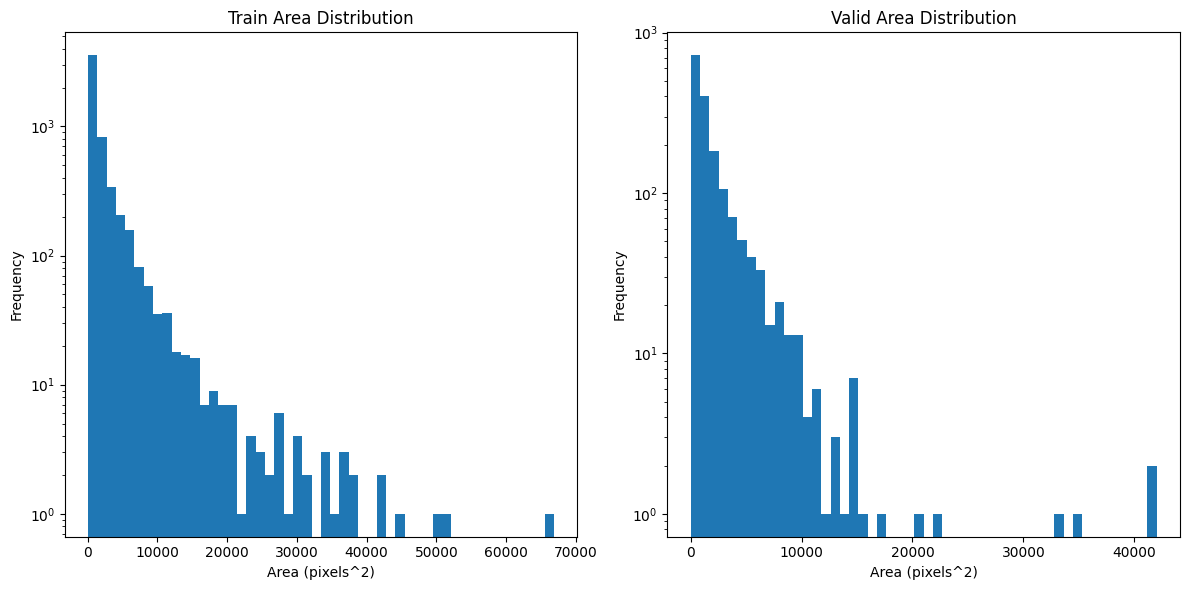

In [ ]:
# Load the original dataframes again to work with the original annotations
train_df = pd.read_csv(os.path.join(train_dir, "_annotations.csv"))
valid_df = pd.read_csv(os.path.join(valid_dir, "_annotations.csv"))

# Calculate area and add to the dataframes
train_df['area'] = (train_df['xmax'] - train_df['xmin']) * (train_df['ymax'] - train_df['ymin'])
valid_df['area'] = (valid_df['xmax'] - valid_df['xmin']) * (valid_df['ymax'] - valid_df['ymin'])

# Analyze the distribution of areas
print("Train Area Distribution:")
display(train_df['area'].describe())

print("\nValid Area Distribution:")
display(valid_df['area'].describe())

# Optional: Visualize area distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_df['area'], bins=50)
plt.title('Train Area Distribution')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale for frequency to see smaller values

plt.subplot(1, 2, 2)
plt.hist(valid_df['area'], bins=50)
plt.title('Valid Area Distribution')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale for frequency

plt.tight_layout()
plt.show()

In [ ]:
# Define area thresholds based on distribution analysis (e.g., remove areas below 50)
min_area_threshold = 50
max_area_threshold = float('inf') # No upper limit for now

# Filter the dataframes based on area thresholds
filtered_train_df = train_df[(train_df['area'] >= min_area_threshold) & (train_df['area'] <= max_area_threshold)].copy()
filtered_valid_df = valid_df[(valid_df['area'] >= min_area_threshold) & (valid_df['area'] <= max_area_threshold)].copy()

print(f"Original train annotations: {len(train_df)}")
print(f"Filtered train annotations: {len(filtered_train_df)}")
print(f"Original valid annotations: {len(valid_df)}")
print(f"Filtered valid annotations: {len(filtered_valid_df)}")


# Redefine the patch extraction function to accept a DataFrame
def extract_and_preprocess_patches_from_df(df, img_dir, patch_size=(64, 64)):
    """Extracts patches from a DataFrame of annotations, resizes, and normalizes."""
    patches = []
    labels = [] # Assuming all annotated objects are microplastics (label 1)

    # Get unique filenames to avoid reading the same image multiple times
    unique_filenames = df['filename'].unique()
    img_cache = {} # Cache images to avoid rereading

    for img_filename in unique_filenames:
        img_path = os.path.join(img_dir, img_filename)

        if img_filename in img_cache:
            img = img_cache[img_filename]
        else:
            img = cv2.imread(img_path)
            if img is None:
                # print(f"Could not read image: {img_path}. Skipping annotations for this image.")
                continue
            img_cache[img_filename] = img # Cache the read image

        # Get annotations for the current image
        image_annotations = df[df['filename'] == img_filename]

        h, w, _ = img.shape

        for index, row in image_annotations.iterrows():
            # Ensure bounding box coordinates are within image bounds
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(w, xmax)
            ymax = min(h, ymax)

            # Extract patch
            patch = img[ymin:ymax, xmin:xmax]

            # Resize patch
            if patch.shape[0] > 0 and patch.shape[1] > 0: # Check if patch is not empty
                patch_resized = cv2.resize(patch, patch_size)
                patches.append(patch_resized)
                labels.append(1) # Label 1 for microplastic

    # Convert lists to NumPy arrays and normalize
    patches_np = np.array(patches)
    labels_np = np.array(labels)

    if patches_np.size > 0:
        patches_np = patches_np / 255.0

    return patches_np, labels_np

# Extract patches and labels using the filtered dataframes
X_train_filtered, y_train_filtered = extract_and_preprocess_patches_from_df(filtered_train_df, train_dir)
X_valid_filtered, y_valid_filtered = extract_and_preprocess_patches_from_df(filtered_valid_df, valid_dir)

# Print the shapes of the new arrays
print("\nFiltered Train patches shape:", X_train_filtered.shape)
print("Filtered Train labels shape:", y_train_filtered.shape)
print("Filtered Valid patches shape:", X_valid_filtered.shape)
print("Filtered Valid labels shape:", y_valid_filtered.shape)

Original train annotations: 5425
Filtered train annotations: 5416
Original valid annotations: 1701
Filtered valid annotations: 1692

Filtered Train patches shape: (5416, 64, 64, 3)
Filtered Train labels shape: (5416,)
Filtered Valid patches shape: (1692, 64, 64, 3)
Filtered Valid labels shape: (1692,)


In [ ]:
print("I am ready to define a more advanced CNN model for microplastic detection.")
print("\nPlease choose which of the following advanced CNN concepts you would like to include in the new model architecture:")
print("- 1. Using different activation functions (e.g., Leaky ReLU, Swish)")
print("- 2. Employing different pooling strategies (e.g., Global Average Pooling)")
print("- 3. Adding more complex layer types (e.g., Inception modules, Residual blocks)")
print("- 4. Incorporating Batch Normalization layers")
print("- 5. Using more advanced optimizers (can also be set during compilation, but can be discussed now)")
print("\nPlease provide the number(s) corresponding to your choices.")

I am ready to define a more advanced CNN model for microplastic detection.

Please choose which of the following advanced CNN concepts you would like to include in the new model architecture:
- 1. Using different activation functions (e.g., Leaky ReLU, Swish)
- 2. Employing different pooling strategies (e.g., Global Average Pooling)
- 3. Adding more complex layer types (e.g., Inception modules, Residual blocks)
- 4. Incorporating Batch Normalization layers
- 5. Using more advanced optimizers (can also be set during compilation, but can be discussed now)

Please provide the number(s) corresponding to your choices.


In [ ]:
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# New CNN architecture with Batch Normalization and Global Average Pooling
advanced_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Using Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')   # Binary classification: microplastic / non-microplastic
])

advanced_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

print("Advanced CNN model defined:")
advanced_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Advanced CNN model defined:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

## Model training

### Subtask:
Train the newly defined advanced CNN model using the filtered microplastic patches.


**Reasoning**:
Train the advanced CNN model using the filtered data and the defined EarlyStopping callback.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the advanced model
advanced_history = advanced_model.fit(
    X_train_filtered, y_train_filtered,
    validation_data=(X_valid_filtered, y_valid_filtered),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9899 - loss: 0.0330 - val_accuracy: 0.9959 - val_loss: 0.1456
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 1.0637e-04 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 3.8283e-05 - val_accuracy: 1.0000 - val_loss: 6.5790e-04
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 1.8169e-05 - val_accuracy: 1.0000 - val_loss: 2.7834e-05
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1545e-05 - val_accuracy: 1.0000 - val_loss: 5.5622e-06
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.0528e-06 - val_accuracy: 1.0000 - val_loss: 1.5320e-06
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.7995e-06 - val_accuracy: 1.0000 - val_loss: 1.5444e-06
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accu

In [ ]:
# Evaluate the trained advanced model on the filtered validation data
evaluation_results = advanced_model.evaluate(X_valid_filtered, y_valid_filtered, verbose=0)

# Store evaluation results
validation_loss = evaluation_results[0]
validation_accuracy = evaluation_results[1]

# Print evaluation results
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Loss: 0.0000
Validation Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


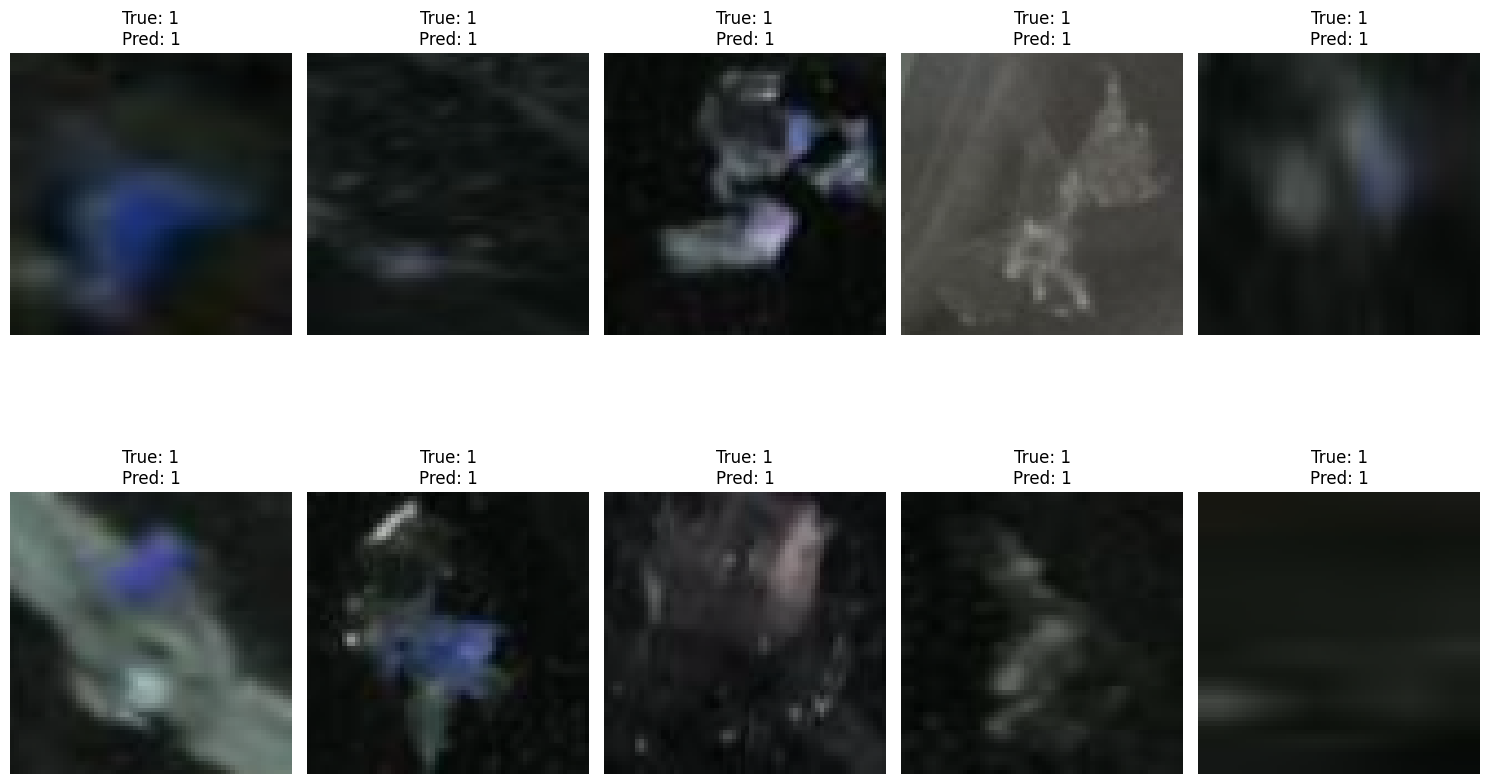

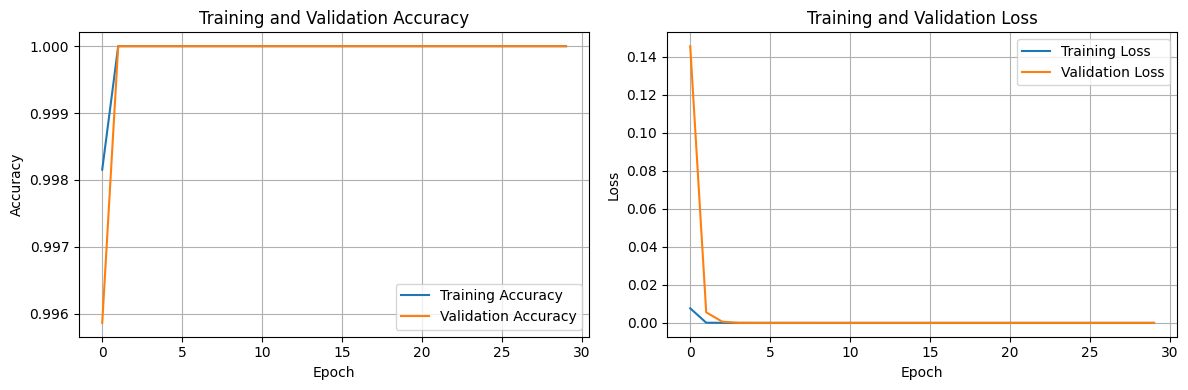

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select a few sample images from the filtered validation dataset
num_samples = 10
sample_indices = np.random.choice(len(X_valid_filtered), num_samples, replace=False)
sample_images = X_valid_filtered[sample_indices]
sample_true_labels = y_valid_filtered[sample_indices]

# Use the trained advanced_model to predict
sample_predictions = advanced_model.predict(sample_images)
sample_predicted_labels = (sample_predictions > 0.5).astype(int).flatten() # Convert probabilities to binary labels

# Display sample images with true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_true_labels[i]}\nPred: {sample_predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(advanced_history.history['accuracy'], label='Training Accuracy')
plt.plot(advanced_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(advanced_history.history['loss'], label='Training Loss')
plt.plot(advanced_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Detected potential microplastics: 23


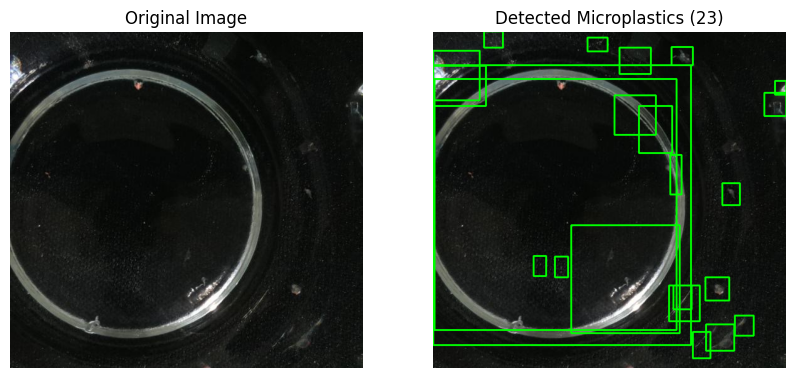

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


image_path = "/content/dataset/valid/c--176-_jpg.rf.1d4a742d368cae50f384976f39d59ed4.jpg"

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: Image not found at {image_path}")
else:
    # Step 1: Read the image
    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not read image at {image_path}")
    else:
        # Step 2: Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Step 3: Apply Gaussian blur to reduce noise
        blur = cv2.GaussianBlur(gray, (5,5), 0)

        # Step 4: Adaptive Thresholding (more robust to lighting variations)
        # Use ADAPTIVE_THRESH_GAUSSIAN_C and OTSU for potentially better results
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)

        # If adaptive thresholding doesn't work well, you can try OTSU's thresholding again:
        # _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


        # Step 5: Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Step 6: Draw bounding boxes and count detected particles based on area
        result_img = img.copy()
        detected_count = 0
        min_area_threshold = 100 # Adjust this value based on what looks like microplastics

        for c in contours:
            area = cv2.contourArea(c)
            if area > min_area_threshold:  # Filter by area
                detected_count += 1
                x, y, w, h = cv2.boundingRect(c)
                cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 2) # Draw green rectangle

        print(f"Detected potential microplastics: {detected_count}")

        # Step 7: Display results
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Microplastics ({detected_count})")
        plt.axis('off')

        plt.show()